In [9]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from util.visualizer import COCOVisualizer
from util import box_ops

from PIL import Image
import datasets.transforms as T
import json

In [10]:
# Prepare model
%cd /home/md703/Documents/CVPDL/CVPDL_hw1/code
model_config_path = "config/DINO/DINO_4scale.py"
model_checkpoint_path = "ckpt/checkpoint.pth"

args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/home/md703/Documents/CVPDL/CVPDL_hw1/code


/home/md703/anaconda3/envs/objdt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/md703/anaconda3/envs/objdt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

### 1. For validation

In [12]:
%cd ../dataset
folder_path='./valid'

image_name=[]
file_names = os.listdir(folder_path)
for file_name in file_names:
    if file_name[:3]=='IMG':
        image_name.append(file_name)

output_json={}
for img in image_name:
    im = Image.open(folder_path+f"/{img}").convert("RGB") # load image
    w, h = im.size
    orig_target_sizes=torch.as_tensor([int(h), int(w)])
    
    # transform images
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image, _ = transform(im, None)

    # predict images
    output = model.cuda()(image[None].cuda())
    output = postprocessors['bbox'](output, torch.Tensor([[h, w]]).cuda())[0]

    # save predict results 
    thershold = 0.3 # set a thershold
    scores_ = output['scores']
    labels_ = output['labels']
    boxes_ = output['boxes']
    select_mask = scores_ > thershold

    scores = scores_.tolist()
    labels = labels_.tolist()
    boxes = boxes_.tolist()

    output_json[img] = {
            'boxes': boxes,
            'labels': labels,
            'scores': scores
        }

json_data = json.dumps(output_json, indent=4)
with open('output_for_validation.json', 'w') as json_file:
    json_file.write(json_data)


/home/md703/Documents/CVPDL/CVPDL_hw1/dataset


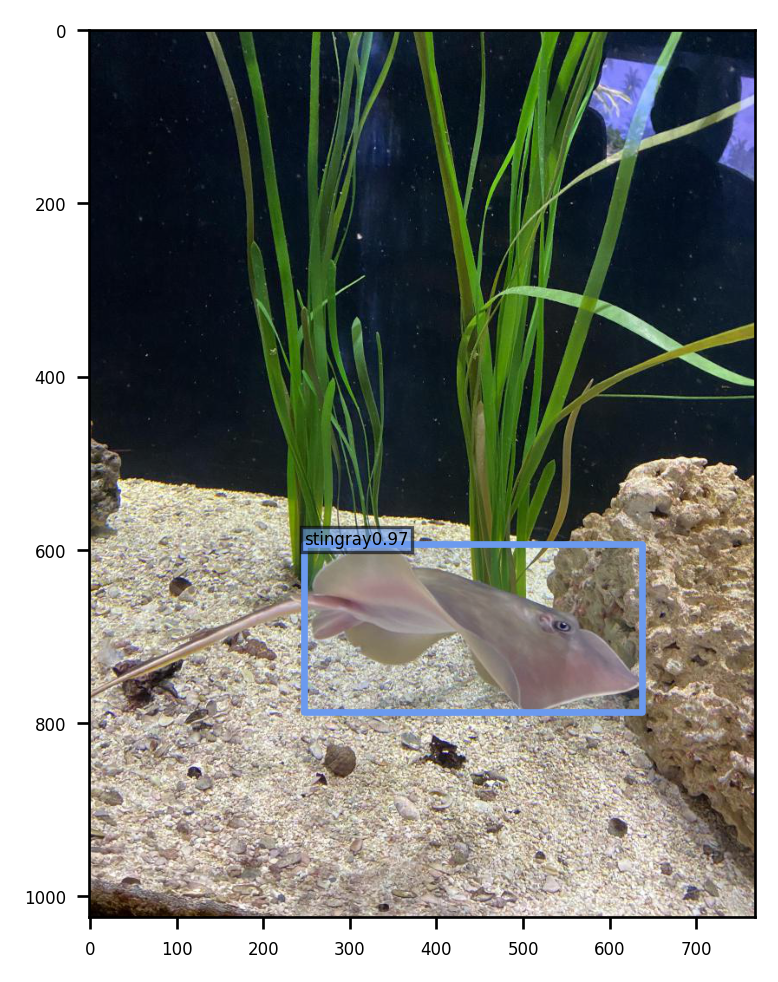

In [13]:
# Visualize outputs
scores = scores_[select_mask].tolist()
labels = labels_[select_mask].tolist() 

vslzr = COCOVisualizer()
boxes = box_ops.box_xyxy_to_cxcywh(boxes_[select_mask])

box_label = [id2name[int(item)] for item in labels]
pred_dict = {
    'boxes': boxes,
    'size': torch.Tensor([1, 1]),
    'box_label': box_label,
    'scores' : scores
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=240)

In [14]:
# Evaluate vallidation set
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import torch
pred_path = '../dataset/output_for_validation.json'
target_path = '../dataset/annotations/valid.json'
def get_gt_data(imageID, annotations):
    gt_data = {'boxes':[],
               'labels':[],
               'image_id':[],
               'area':[],
               'iscrowd':[]}
    
    for annotation in annotations:
        if annotation["image_id"] == imageID:
            bbox = annotation['bbox']
            bbox[2] += bbox[0]
            bbox[3] += bbox[1]
            gt_data['boxes'].append(bbox)
            gt_data['labels'].append(annotation['category_id'])
            gt_data['image_id'].append(imageID)
            gt_data['area'].append(annotation['area'])
            gt_data['iscrowd'].append(annotation['iscrowd'])
    return gt_data

with open(pred_path, 'r') as f:
    preds = json.load(f)

with open(target_path, 'r') as f:
    gt = json.load(f)
fname_to_imageID = {}

for image in gt["images"]:
    fname_to_imageID[image["file_name"]] = image["id"]
metric = MeanAveragePrecision()
device = 'cuda'
for fname, pred in tqdm(preds.items()):
    pred = [{k: torch.tensor(v).to(device) for k, v in pred.items()}]
    imageID = fname_to_imageID[fname]
    target = get_gt_data(imageID, gt["annotations"])
    target = [{k: torch.tensor(v).to(device) for k, v in target.items()}]
    metric.update(pred, target)
    # print(pred)
    # print(target)
    
result = metric.compute()
print(result)


100%|██████████| 127/127 [00:00<00:00, 997.93it/s] 


{'map': tensor(0.5213), 'map_50': tensor(0.8101), 'map_75': tensor(0.5314), 'map_small': tensor(0.2119), 'map_medium': tensor(0.4267), 'map_large': tensor(0.6666), 'mar_1': tensor(0.2520), 'mar_10': tensor(0.5507), 'mar_100': tensor(0.6654), 'mar_small': tensor(0.4225), 'mar_medium': tensor(0.5920), 'mar_large': tensor(0.7660), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)}


### 2. For test

In [15]:
folder_path='./test'

image_name=[]
file_names = os.listdir(folder_path)
for file_name in file_names:
    if file_name[:3]=='IMG':
        image_name.append(file_name)

output_json={}
for img in image_name:
    image = Image.open(folder_path+f"/{img}").convert("RGB") # load image
    w, h = image.size
    orig_target_sizes=torch.as_tensor([int(h), int(w)])
    
    # transform images
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image, _ = transform(image, None)

    # predict images
    output = model.cuda()(image[None].cuda())
    output = postprocessors['bbox'](output, torch.Tensor([[h, w]]).cuda())[0]


    # save predict results 
    thershold = 0.3 # set a thershold
    scores_ = output['scores']
    labels_ = output['labels']
    boxes_ = output['boxes']
    select_mask = scores_ > thershold

    scores = scores_.tolist()
    labels = labels_.tolist()
    boxes = boxes_.tolist()

    output_json[img] = {
            'boxes': boxes,
            'labels': labels,
            'scores': scores
        }

json_data = json.dumps(output_json, indent=4)
with open('output.json', 'w') as json_file:
    json_file.write(json_data)


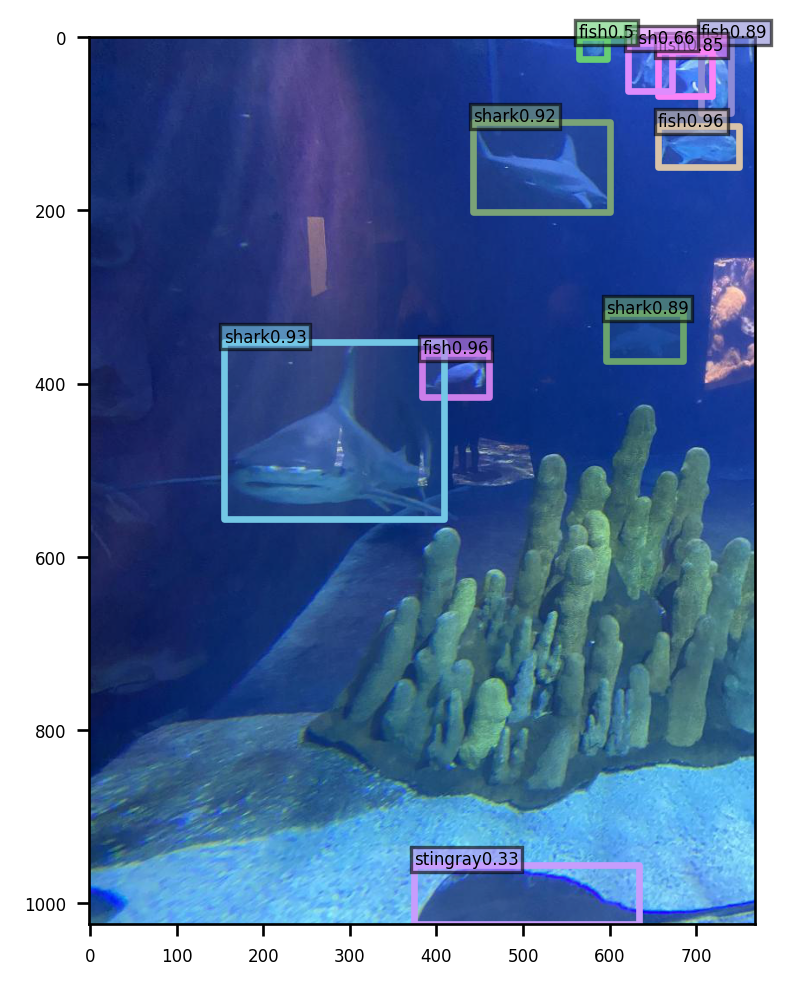

In [16]:
# Visualize outputs
scores = scores_[select_mask].tolist()
labels = labels_[select_mask].tolist() 

vslzr = COCOVisualizer()
boxes = box_ops.box_xyxy_to_cxcywh(boxes_[select_mask])

box_label = [id2name[int(item)] for item in labels]
pred_dict = {
    'boxes': boxes,
    'size': torch.Tensor([1, 1]),
    'box_label': box_label,
    'scores' : scores
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=240)